# Predict Daily Max Temperature 
The goal of this project is to explore the random forest for supervised learning of building a regression model.
<br> The algorithms will be explored using an example of predicting daily max temperature in Seatle, WA.  <br> The data could be original downloaded from the National Oceanic and Atmospheric Administration's (NOAA) [Climate Data Online Tool](https://www.ncdc.noaa.gov/cdo-web/).

## 1. Build the Random Forest Model
We need a quick start and build the first version random forest model. The whole process could be divided into three parts: 
1. Data
   <br> Collect data, load data, preliminary data analysis, data visualization, handling missing values and extremes values, encode categorial variables, construct features and labels, split data into training data and testing data
2. Model 
   <br> Decide the machine learning algorithms, the model artichecture, hyperparameters, k-fold cross validation, define the performance metric, define the baseline performance 
3. Post Analysis 
   <br> Analyze variables importance, Visualize output, Compare the performance metrics, Error Analysis, Determine the model underfitting or overfitting problems. 

### Load Data

In [18]:
import pandas as pd
features = pd.read_csv('./temps.csv')
features.head() #check the first five rows

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


### Data Analysis

In [19]:
features.shape # check the size of the data set, we see 348 rows and 12 columns 
               # 12 means there are 12 variables: 
               # 'year', 'month', 'day', 'week', 'temp_2', 'temp_1', 'average', 'actual', 
               # 'forecast_noaa', 'forest_acc', 'forecast_under', 'friend' 
               # 348 rows mean the length of each variable is 348

(348, 12)

Following are explanations of the columns:
<br> year: 2016 for all data points
<br> month: number for month of the year
<br> day: number for day of the year
<br> week: day of the week as a character string
<br> temp_2: max temperature 2 days prior
<br> temp_1: max temperature 1 day prior
<br> average: historical average max temperature
<br> actual: max temperature measurement
<br> forecast_noaa: forecast daily max temperature from NOAA 
<br> forecast_acc: forecast daily max temperature from ACCUWEATHER 
<br> forecast_under: forecast daily max temperature from UNDERGROUND 
<br> friend: your friend’s prediction, a random number between 20 below the average and 20 above the average

<br> As we would like to make a prediction of our own, we don't need the forecasted daily max temperature from NOAA, ACC and UNDERGROUND. Thus, we will drop these three columns in our features. 

In [20]:
# drop 'forecast_noaa', 'forecast_acc', and 'forecast_under' 
features = features.drop(['forecast_noaa', 'forecast_acc', 'forecast_under'], axis=1) 

In [21]:
features.describe() # the describe statistics for the dataset 

,year,month,day,temp_2,temp_1,average,actual,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,95.000000


In [22]:
# Use datetime for dealing with dates
import datetime

# Get years, months, and days
years = features['year']
months = features['month']
days = features['day']

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

In [23]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt

%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

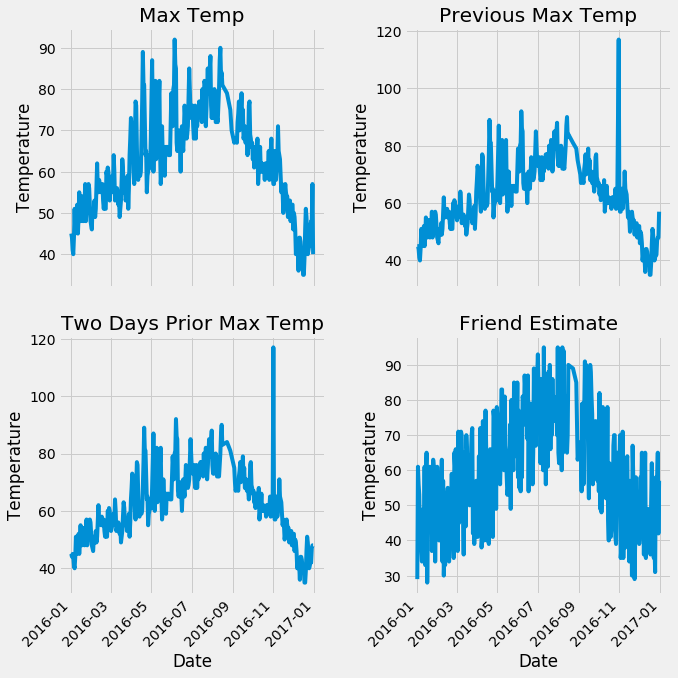

In [24]:
# Set up the plotting layout
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (10,10))
fig.autofmt_xdate(rotation = 45)

# Actual max temperature measurement
ax1.plot(dates, features['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature'); ax1.set_title('Max Temp')

# Temperature from 1 day ago
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature'); ax2.set_title('Previous Max Temp')

# Temperature from 2 days ago
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature'); ax3.set_title('Two Days Prior Max Temp')

# Friend Estimate
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature'); ax4.set_title('Friend Estimate')

plt.tight_layout(pad=2)

#### Data Preparation

One hot encoding takes this:

| week |
|------|
| Mon  |
| Tue  |
| Wed  |
| Thu  |
| Fri  |

and converts it into:

| Mon | Tue | Wed | Thu | Fri |
|-----|-----|-----|-----|-----|
| 1   | 0   | 0   | 0   | 0   |
| 0   | 1   | 0   | 0   | 0   |
| 0   | 0   | 1   | 0   | 0   |
| 0   | 0   | 0   | 1   | 0   |
| 0   | 0   | 0   | 0   | 1   |

In [25]:
# One-hot encode categorical features
features = pd.get_dummies(features)
features.head(5)

,year,month,day,temp_2,temp_1,average,actual,friend,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,2016,1,1,45,45,45.6,45,29,1,0,0,0,0,0,0
1,2016,1,2,44,45,45.7,44,61,0,0,1,0,0,0,0
2,2016,1,3,45,44,45.8,41,56,0,0,0,1,0,0,0
3,2016,1,4,44,41,45.9,40,53,0,1,0,0,0,0,0
4,2016,1,5,41,40,46.0,44,41,0,0,0,0,0,1,0


In [26]:
print('Shape of features after one-hot encoding:', features.shape)

Shape of features after one-hot encoding: (348, 15)


### Features and Labels and Convert Data to Arrays

In [27]:
# Use numpy to convert to arrays
import numpy as np

# Labels are the values we want to predict
labels = np.array(features['actual'])

# Remove the labels from the features
# axis 1 refers to the columns
features= features.drop('actual', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

### Training and Testing Sets

In [28]:
# import train_test_split from sklearn 
from sklearn.model_selection import train_test_split 

# split data into training and testing data set 
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.25, 
                                                                           random_state=42)

In [29]:
print("shape of train features:", train_features.shape)
print("shape of test features:", test_features.shape)
print("shape of train labels:", train_labels.shape)
print("shape of test labels:", test_labels.shape)

shape of train features: (261, 14)
shape of test features: (87, 14)
shape of train labels: (261,)
shape of test labels: (87,)


### Establish baseline 
We estimate a baseline, if our model could not beat that baseline, we would say the model is a fail. 

In [30]:
# baseline predictions are the historical average 
# The baseline predictions are the historical averages
baseline_preds = test_features[:, feature_list.index('average')]

# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2), 'degrees.')

Average baseline error:  5.06 degrees.


### Train Model

In [41]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
rf = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Train the model on training data
rf.fit(train_features, train_labels);

### Make Predictions on Test Data

In [32]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 3.83 degrees.


### Determine Performance Metrics

In [33]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 93.99 %.


### Interpret Model Results

### Variable Importances

In [34]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: temp_1               Importance: 0.69
Variable: average              Importance: 0.2
Variable: day                  Importance: 0.03
Variable: friend               Importance: 0.03
Variable: temp_2               Importance: 0.02
Variable: month                Importance: 0.01
Variable: year                 Importance: 0.0
Variable: week_Fri             Importance: 0.0
Variable: week_Mon             Importance: 0.0
Variable: week_Sat             Importance: 0.0
Variable: week_Sun             Importance: 0.0
Variable: week_Thurs           Importance: 0.0
Variable: week_Tues            Importance: 0.0
Variable: week_Wed             Importance: 0.0


### Model with Two Most Important Features

In [35]:
# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators= 1000, random_state=42)

# Extract the two most important features
important_indices = [feature_list.index('temp_1'), feature_list.index('average')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]

# Train the random forest
rf_most_important.fit(train_important, train_labels)

# Make predictions and determine the error
predictions = rf_most_important.predict(test_important)

errors = abs(predictions - test_labels)

# Display the performance metrics
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

mape = np.mean(100 * (errors / test_labels))
accuracy = 100 - mape

print('Accuracy:', round(accuracy, 2), '%.')

Mean Absolute Error: 3.91 degrees.
Accuracy: 93.78 %.


### Visualizations
### Variable Importances

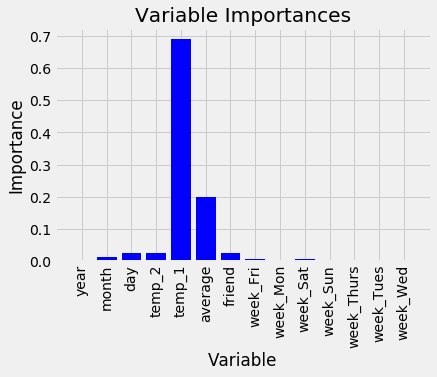

In [40]:
# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, color='blue', orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances'); 

### Predictions and Actual Values

In [37]:
# Dates of training values
months = features[:, feature_list.index('month')]
days = features[:, feature_list.index('day')]
years = features[:, feature_list.index('year')]

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'actual': labels})

# Dates of predictions
months = test_features[:, feature_list.index('month')]
days = test_features[:, feature_list.index('day')]
years = test_features[:, feature_list.index('year')]

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

# Convert to datetime objects
test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions}) 

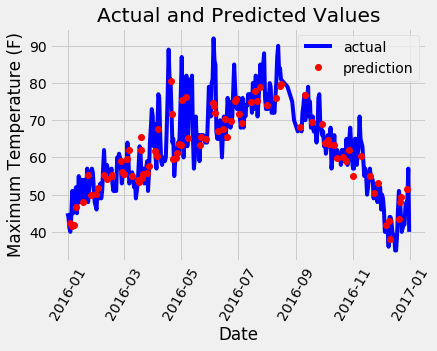

In [38]:
# Plot the actual values
plt.plot(true_data['date'], true_data['actual'], 'b-', label = 'actual')

# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()

# Graph labels
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');

### Targets and Data Visualization

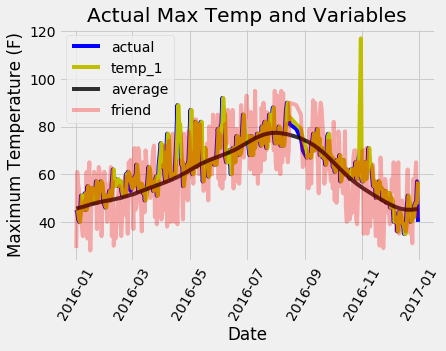

In [39]:
# Make the data accessible for plotting
true_data['temp_1'] = features[:, feature_list.index('temp_1')]
true_data['average'] = features[:, feature_list.index('average')]
true_data['friend'] = features[:, feature_list.index('friend')]

# Plot all the data as lines
plt.plot(true_data['date'], true_data['actual'], 'b-', label  = 'actual', alpha = 1.0)
plt.plot(true_data['date'], true_data['temp_1'], 'y-', label  = 'temp_1', alpha = 1.0)
plt.plot(true_data['date'], true_data['average'], 'k-', label = 'average', alpha = 0.8)
plt.plot(true_data['date'], true_data['friend'], 'r-', label = 'friend', alpha = 0.3)

# Formatting plot
plt.legend(); plt.xticks(rotation = '60');

# Lables and title
plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual Max Temp and Variables');

## 2. Improve the Random Forest Model From Data
Now we have built the random forest model to successfully predict the daily max temperature in Seatle, WA and achieve a 94% accuracy for our prediction. We also identified two most important features and used these only two features to predict the target. The accuracy could be as high as 93.78%, which is very close to the performance with all features. 

Our next question is: **could we further improve our performance?**
<br> This could be done from two perspectives: (1) collect more data, (2) find the best model via hyperparameter tuning. 
<br> We now try the first way. 

### Collect More Data

All data is obtained from the [NOAA climate data online](https://www.ncdc.noaa.gov/cdo-web/) tool.  

This time we will use 6 years of historical data and include some additional variables to augment the temperature features used in the simple model. 

In [43]:
# Pandas is used for data manipulation
import pandas as pd

# Read in data as a dataframe
features = pd.read_csv('./temps_extended.csv')
features.head()

,year,month,day,weekday,ws_1,prcp_1,snwd_1,temp_2,temp_1,average,actual,friend
0,2011,1,1,Sat,4.92,0.00,0,36,37,45.6,40,40
1,2011,1,2,Sun,5.37,0.00,0,37,40,45.7,39,50
2,2011,1,3,Mon,6.26,0.00,0,40,39,45.8,42,42
3,2011,1,4,Tues,5.59,0.00,0,39,42,45.9,38,59
4,2011,1,5,Wed,3.80,0.03,0,42,38,46.0,45,39


In [44]:
print('We have {} days of data with {} variables.'.format(*features.shape))

We have 2191 days of data with 12 variables.


### Numerical and Visual Inspection of Data

In [45]:
round(features.describe(), 2)

,year,month,day,ws_1,prcp_1,snwd_1,temp_2,temp_1,average,actual,friend
count,2191.00,2191.00,2191.00,2191.00,2191.00,2191.00,2191.00,2191.00,2191.00,2191.00,2191.00
mean,2013.50,6.52,15.71,7.37,0.12,0.01,61.17,61.18,60.29,61.18,60.31
std,1.71,3.45,8.80,3.15,0.25,0.15,13.09,13.08,10.73,13.08,15.87
min,2011.00,1.00,1.00,0.89,0.00,0.00,29.00,29.00,45.10,29.00,25.00
25%,2012.00,4.00,8.00,5.14,0.00,0.00,51.00,51.00,50.10,51.00,49.00
50%,2014.00,7.00,16.00,6.71,0.00,0.00,60.00,60.00,58.80,60.00,60.00
75%,2015.00,10.00,23.00,9.17,0.12,0.00,71.00,71.00,70.20,71.00,71.00
max,2017.00,12.00,31.00,21.25,2.20,3.00,96.00,96.00,77.40,96.00,97.00


In [46]:
# Use datetime for dealing with dates
import datetime

# Get years, months, and days
years = features['year']
months = features['month']
days = features['day']

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt

%matplotlib inline

# Set the style
plt.style.use('fivethirtyeight')

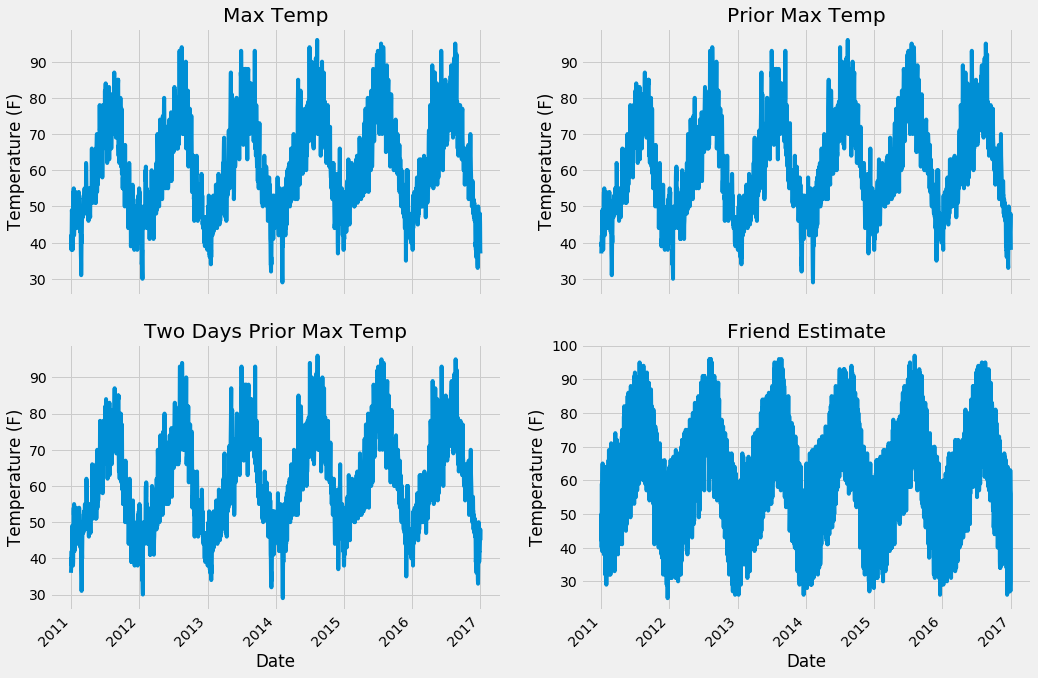

In [47]:
# Set up the plotting layout
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (15,10))
fig.autofmt_xdate(rotation = 45)

# Actual max temperature measurement
ax1.plot(dates, features['actual'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature (F)'); ax1.set_title('Max Temp')

# Temperature from 1 day ago
ax2.plot(dates, features['temp_1'])
ax2.set_xlabel(''); ax2.set_ylabel('Temperature (F)'); ax2.set_title('Prior Max Temp')

# Temperature from 2 days ago
ax3.plot(dates, features['temp_2'])
ax3.set_xlabel('Date'); ax3.set_ylabel('Temperature (F)'); ax3.set_title('Two Days Prior Max Temp')

# Friend Estimate
ax4.plot(dates, features['friend'])
ax4.set_xlabel('Date'); ax4.set_ylabel('Temperature (F)'); ax4.set_title('Friend Estimate')

plt.tight_layout(pad=2)

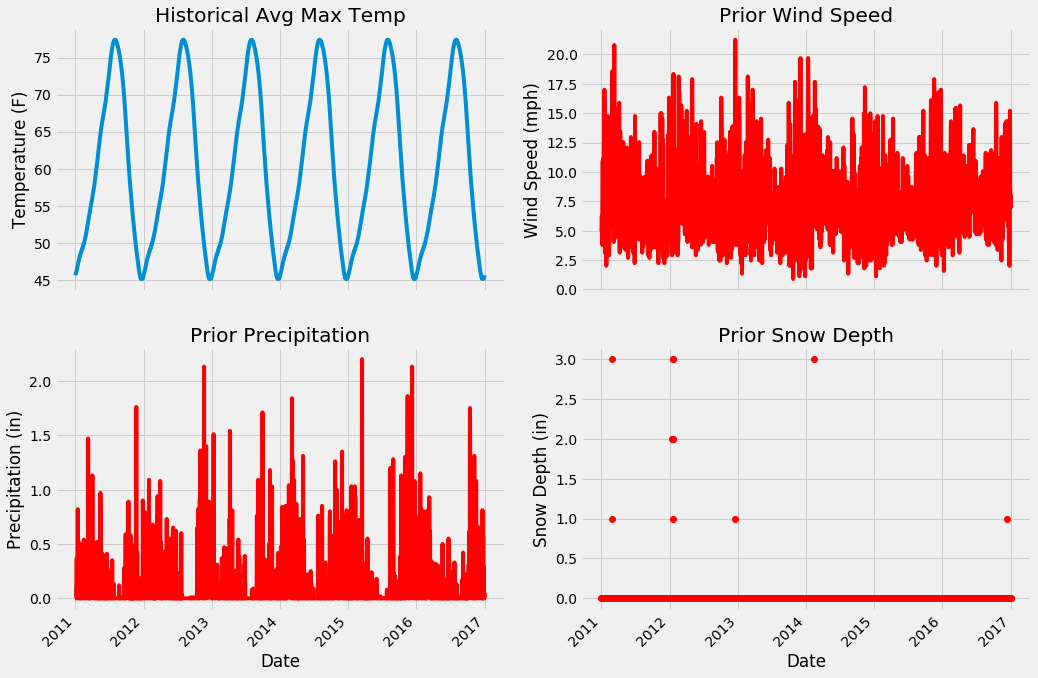

In [48]:
# Set up the plotting layout
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize = (15,10))
fig.autofmt_xdate(rotation = 45)

# Historical Average Max Temp
ax1.plot(dates, features['average'])
ax1.set_xlabel(''); ax1.set_ylabel('Temperature (F)'); ax1.set_title('Historical Avg Max Temp')

# Prior Avg Wind Speed 
ax2.plot(dates, features['ws_1'], 'r-')
ax2.set_xlabel(''); ax2.set_ylabel('Wind Speed (mph)'); ax2.set_title('Prior Wind Speed')

# Prior Precipitation
ax3.plot(dates, features['prcp_1'], 'r-')
ax3.set_xlabel('Date'); ax3.set_ylabel('Precipitation (in)'); ax3.set_title('Prior Precipitation')

# Prior Snowdepth
ax4.plot(dates, features['snwd_1'], 'ro')
ax4.set_xlabel('Date'); ax4.set_ylabel('Snow Depth (in)'); ax4.set_title('Prior Snow Depth')

plt.tight_layout(pad=2)

### Pairplots

In [52]:
# Create columns of seasons for pair plotting colors
seasons = []

for month in features['month']:
    if month in [1, 2, 12]:
        seasons.append('winter')
    elif month in [3, 4, 5]:
        seasons.append('spring')
    elif month in [6, 7, 8]:
        seasons.append('summer')
    elif month in [9, 10, 11]:
        seasons.append('fall')

# Will only use six variables for plotting pairs
reduced_features = features[['temp_1', 'prcp_1', 'average', 'actual']]
reduced_features['season'] = seasons

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


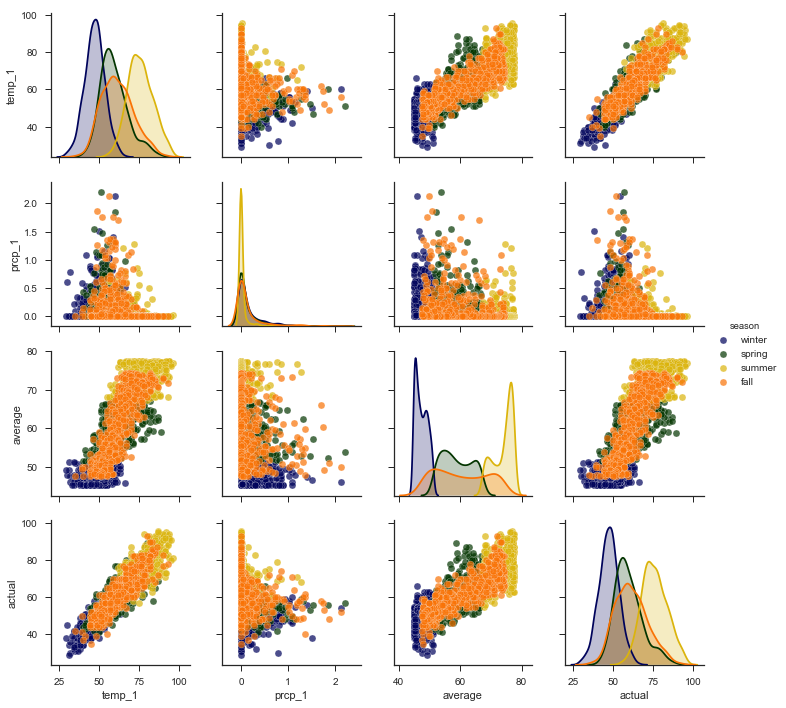

In [53]:
# Use seaborn for pair plots
import seaborn as sns
sns.set(style="ticks", color_codes=True);

# Create a custom color palete
palette = sns.xkcd_palette(['dark blue', 'dark green', 'gold', 'orange'])

# Make the pair plot with a some aesthetic changes
sns.pairplot(reduced_features, hue = 'season', diag_kind = 'kde', palette= palette, plot_kws=dict(alpha = 0.7),
                   diag_kws=dict(shade=True)); 

### Data Preparation

In [54]:
# One Hot Encoding
features = pd.get_dummies(features)

# Extract features and labels
labels = features['actual']
features = features.drop('actual', axis = 1)

# List of features for later use
feature_list = list(features.columns)

# Convert to numpy arrays
import numpy as np

features = np.array(features)
labels = np.array(labels)

# Training and Testing Sets
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, 
                                                                            test_size = 0.25, random_state = 42)

In [55]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (1643, 17)
Training Labels Shape: (1643,)
Testing Features Shape: (548, 17)
Testing Labels Shape: (548,)


### Establish New Baseline

In [56]:
# Find the original feature indices 
original_feature_indices = [feature_list.index(feature) for feature in
                                      feature_list if feature not in
                                      ['ws_1', 'prcp_1', 'snwd_1']]

# Create a test set of the original features
original_test_features = test_features[:, original_feature_indices]

# Make predictions on test data using the model trained on original data
baseline_predictions = rf.predict(original_test_features)

# Performance metrics
baseline_errors = abs(baseline_predictions - test_labels)

print('Metrics for Random Forest Trained on Original Data')
print('Average absolute error:', round(np.mean(baseline_errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
baseline_mape = 100 * np.mean((baseline_errors / test_labels))

# Calculate and display accuracy
baseline_accuracy = 100 - baseline_mape
print('Accuracy:', round(baseline_accuracy, 2), '%.')

Metrics for Random Forest Trained on Original Data
Average absolute error: 4.3 degrees.
Accuracy: 92.5 %.


### Train on Expanded Data and Features

In [57]:
# Instantiate random forest and train on new features
from sklearn.ensemble import RandomForestRegressor

rf_exp = RandomForestRegressor(n_estimators= 1000, random_state=42)
rf_exp.fit(train_features, train_labels);

### Metrics for Expanded Data and Features

In [58]:
# Make predictions on test data
predictions = rf_exp.predict(test_features)

# Performance metrics
errors = abs(predictions - test_labels)

print('Metrics for Random Forest Trained on Expanded Data')
print('Average absolute error:', round(np.mean(errors), 4), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = np.mean(100 * (errors / test_labels))

# Compare to baseline
improvement_baseline = 100 * abs(mape - baseline_mape) / baseline_mape
print('Improvement over baseline:', round(improvement_baseline, 2), '%.')

# Calculate and display accuracy
accuracy = 100 - mape
print('Accuracy:', round(accuracy, 2), '%.')

Metrics for Random Forest Trained on Expanded Data
Average absolute error: 3.7039 degrees.
Improvement over baseline: 16.61 %.
Accuracy: 93.74 %.


Using more data (more data points and more features) has decreased the absolute error, increased performance relative to the baseline, and increased accuracy.
Although the exact metrics will depend on the random state used, overall, we can be confident using additional high-quality data improves our model.

At this point, our model can predict the maximum temperature for tomrrow with an average error of __3.7__ degrees resulting in an accuracy of __93.7%__.

### Feature Reduction
From previous experience and the graphs produced at the beginning, we know that some features are not useful for our temperature prediction problem. To reduce the number of features, which will reduce runtime, hopefully without significantly reducing performance, we can examine the feature importances from the random forest.

### Feature Importances

In [59]:
# Get numerical feature importances
importances = list(rf_exp.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: temp_1               Importance: 0.83
Variable: average              Importance: 0.06
Variable: ws_1                 Importance: 0.02
Variable: temp_2               Importance: 0.02
Variable: friend               Importance: 0.02
Variable: year                 Importance: 0.01
Variable: month                Importance: 0.01
Variable: day                  Importance: 0.01
Variable: prcp_1               Importance: 0.01
Variable: snwd_1               Importance: 0.0
Variable: weekday_Fri          Importance: 0.0
Variable: weekday_Mon          Importance: 0.0
Variable: weekday_Sat          Importance: 0.0
Variable: weekday_Sun          Importance: 0.0
Variable: weekday_Thurs        Importance: 0.0
Variable: weekday_Tues         Importance: 0.0
Variable: weekday_Wed          Importance: 0.0


#### Visualize Feature Importances

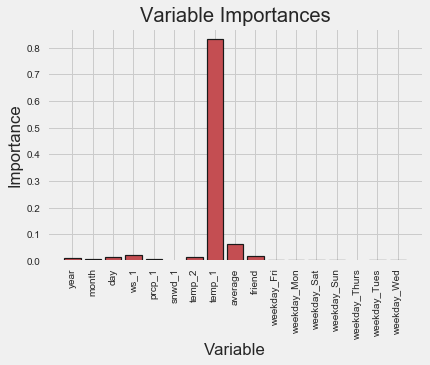

In [60]:
# Reset style 
plt.style.use('fivethirtyeight')

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)

# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

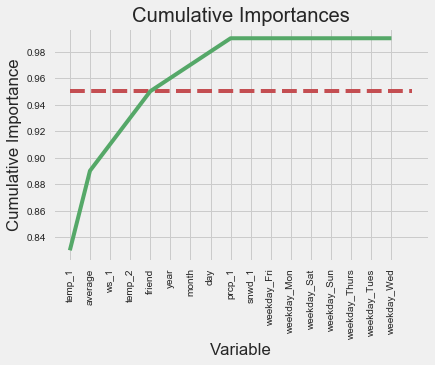

In [61]:
# List of features sorted from most to least important
sorted_importances = [importance[1] for importance in feature_importances]
sorted_features = [importance[0] for importance in feature_importances]

# Cumulative importances
cumulative_importances = np.cumsum(sorted_importances)

# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(sorted_importances), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(x_values, sorted_features, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variable'); plt.ylabel('Cumulative Importance'); plt.title('Cumulative Importances');

### Limit Number of Features 

We will now reduce the number of features in use by the model to only those required to account for 95% of the importance. 
The same number of features must be used in the training and testing sets.

In [62]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
print('Number of features for 95% importance:', np.where(cumulative_importances > 0.95)[0][0] + 1)

Number of features for 95% importance: 6


In [63]:
# Extract the names of the most important features
important_feature_names = [feature[0] for feature in feature_importances[0:6]]
# Find the columns of the most important features
important_indices = [feature_list.index(feature) for feature in important_feature_names]

# Create training and testing sets with only the important features
important_train_features = train_features[:, important_indices]
important_test_features = test_features[:, important_indices]

# Sanity check on operations
print('Important train features shape:', important_train_features.shape)
print('Important test features shape:', important_test_features.shape)

Important train features shape: (1643, 6)
Important test features shape: (548, 6)


### Training on Important Features

In [64]:
# Train the expanded model on only the important features
rf_exp.fit(important_train_features, train_labels);

### Evaluate on Important features

In [65]:
# Make predictions on test data
predictions = rf_exp.predict(important_test_features)

# Performance metrics
errors = abs(predictions - test_labels)

print('Average absolute error:', round(np.mean(errors), 4), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Average absolute error: 3.821 degrees.
Accuracy: 93.56 %.


### Compare Trade-Offs

In [66]:
# Use time library for run time evaluation
import time

# All features training and testing time
all_features_time = []

# Do 10 iterations and take average for all features
for _ in range(10):
    start_time = time.time()
    rf_exp.fit(train_features, train_labels)
    all_features_predictions = rf_exp.predict(test_features)
    end_time = time.time()
    all_features_time.append(end_time - start_time)

all_features_time = np.mean(all_features_time)
print('All features total training and testing time:', round(all_features_time, 2), 'seconds.')

All features total training and testing time: 6.16 seconds.


In [67]:
# Time training and testing for reduced feature set
reduced_features_time = []

# Do 10 iterations and take average
for _ in range(10):
    start_time = time.time()
    rf_exp.fit(important_train_features, train_labels)
    reduced_features_predictions = rf_exp.predict(important_test_features)
    end_time = time.time()
    reduced_features_time.append(end_time - start_time)

reduced_features_time = np.mean(reduced_features_time)
print('Reduced features total training and testing time:', round(reduced_features_time, 2), 'seconds.')

Reduced features total training and testing time: 4.13 seconds.


### Accuracy vs Run-Time

In [68]:
all_accuracy =  100 * (1- np.mean(abs(all_features_predictions - test_labels) / test_labels))
reduced_accuracy = 100 * (1- np.mean(abs(reduced_features_predictions - test_labels) / test_labels))

comparison = pd.DataFrame({'features': ['all (17)', 'reduced (5)'], 
                           'run_time': [round(all_features_time, 2), round(reduced_features_time, 2)],
                           'accuracy': [round(all_accuracy, 2), round(reduced_accuracy, 2)]})

comparison[['features', 'accuracy', 'run_time']]

,features,accuracy,run_time
0,all (17),93.74,6.16
1,reduced (5),93.56,4.13


In [69]:
relative_accuracy_decrease = 100 * (all_accuracy - reduced_accuracy) / all_accuracy
print('Relative decrease in accuracy:', round(relative_accuracy_decrease, 3), '%.')

relative_runtime_decrease = 100 * (all_features_time - reduced_features_time) / all_features_time
print('Relative decrease in run time:', round(relative_runtime_decrease, 3), '%.')

Relative decrease in accuracy: 0.198 %.
Relative decrease in run time: 32.968 %.


## 3. Improve Random Forest Model From Hyperparameter Tuning

In [78]:
# Use only the most important features
train_features = important_train_features[:]
test_features = important_test_features[:]

# Update feature list for visualizations
feature_list = important_feature_names[:]

### Examine the Default Random Forest to Determine Parameters

In [79]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state = 42)

from pprint import pprint

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


### Random Search with Cross Validation

In [80]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [81]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(train_features, train_labels)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True 
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True 
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True, total=   3.8s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=60, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, bootstrap=True, total=   5.4s
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=10, boots

[CV] n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=90, bootstrap=False 
[CV]  n_estimators=1800, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=80, bootstrap=False, total=  11.0s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   45.2s


[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=90, bootstrap=False, total=  10.8s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=90, bootstrap=False, total=  10.9s
[CV] n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=90, bootstrap=False, total=  11.1s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=False, total=  11.5s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=20, bootstrap=True 
[CV]  n_estimator

[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=True, total=   1.2s
[CV] n_estimators=1600, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=90, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=sqrt, max_depth=70, bootstrap=True, total=   1.3s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False, total=   1.0s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=None, bootstrap=False, total=   0.9s
[CV] n_estimators=20

[CV] n_estimators=1000, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=70, bootstrap=False, total=  10.0s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=70, bootstrap=False, total=   9.8s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False, total=   0.7s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=2, max_features=sqrt, max_depth=50, bootstrap=False, total=   0.7s
[CV] n_estimators=600, min

[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=50, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=50, bootstrap=True, total=   6.0s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=50, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True, total=   4.2s
[CV] n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=50, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=50, bootstrap=True, total=   4.1s
[CV] n_estimators=200, min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=1000, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=50, bootstrap=True, total=   4.0s
[CV] n_estimators=200, 

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.0min


[CV]  n_estimators=1800, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=40, bootstrap=True, total=   7.2s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=60, bootstrap=True, total=   2.6s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=1800, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True, total=   7.6s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=False, total=  12.2s
[CV] n_estimators=1800, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=True 
[CV]  n_estimators=200

[CV] n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=2000, min_samples_split=2, min_samples_leaf=1, max_features=sqrt, max_depth=60, bootstrap=True, total=   9.2s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False, total=   2.2s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=True, total=   3.7s
[CV] n_estimators=400, min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=30, bootstrap=False 
[CV]  n_estimators=1200, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=100, bootstrap=True, total=   3.5s
[CV] n_estimators=1200

[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=True, total=   1.0s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=True, total=   1.0s
[CV] n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=True 
[CV]  n_estimators=200, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=None, bootstrap=True, total=   1.1s
[CV] n_estimators=2000, min_samples_split=5, min_samples_leaf=1, max_features=auto, max_depth=10, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=10, bootstrap=False, total=   7.9s
[CV] n_estimators=20

[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False, total=   4.9s
[CV] n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=True 
[CV]  n_estimators=1600, min_samples_split=10, min_samples_leaf=2, max_features=sqrt, max_depth=20, bootstrap=False, total=   4.9s
[CV] n_estimators=1800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=True, total=   5.1s
[CV] n_estimators=1800, min_samples_split=10, min_samples_leaf=4, max_features=sqrt, max_depth=100, bootstrap=True 
[CV]  n_estimators=1200, min_samples_split=2, min_samples_leaf=2, max_features=auto, max_depth=50, bootstrap=True, total=   5.3s
[CV] n_estimators=18

[CV]  n_estimators=200, min_samples_split=10, min_samples_leaf=2, max_features=auto, max_depth=90, bootstrap=True, total=   0.8s
[CV] n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=False 
[CV]  n_estimators=1400, min_samples_split=5, min_samples_leaf=4, max_features=sqrt, max_depth=10, bootstrap=True, total=   3.7s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=False, total=   3.1s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators=1000, min_samples_split=2, min_samples_leaf=1, max_features=auto, max_depth=60, bootstrap=False, total=   6.8s
[CV] n_estimators=600, min_samples_split=10, min_samples_leaf=1, max_features=auto, max_depth=100, bootstrap=False 
[CV]  n_estimators

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.5min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_absolute_error',
          verbose=2)

In [82]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 50,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 1200}

### Evaluation Function

In [83]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))

### Evaluate the Default Model

In [84]:
base_model = RandomForestRegressor(n_estimators = 1000, random_state = 42)
base_model.fit(train_features, train_labels)
evaluate(base_model, test_features, test_labels)

Model Performance
Average Error: 3.8210 degrees.
Accuracy = 93.56%.


### Evaluate the Best Random Search Model

In [85]:
best_random = rf_random.best_estimator_
evaluate(best_random, test_features, test_labels)

Model Performance
Average Error: 3.7243 degrees.
Accuracy = 93.72%.


### Grid Search 

We can now perform grid search building on the result from the random search. 
We will test a range of hyperparameters around the best values returend by random search. 

In [86]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

# Create a based model
rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                           scoring = 'neg_mean_absolute_error', cv = 3, 
                           n_jobs = -1, verbose = 2)

In [87]:
# Fit the grid search to the data
grid_search.fit(train_features, train_labels)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200 
[CV] bootstr

[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.4s


[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samp

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_sam

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   0.8s
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_

[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, m

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   46.7s


[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=1000, total=   3.1s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, 

[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=80, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=80, max_features=3, 

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=2, m

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, mi

[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=8, n_estimators=300, total=   0.8s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=2, min

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200, total=   0.7s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.8min


[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samp

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=8, n_estimators=200 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_sam

[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2

[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=8, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_fea

[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   2.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max

[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   2.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   2.7s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   0.8s
[CV] bootstrap=True, max_depth=100, max_f

[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.6s
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   3.1s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   3.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_f

[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   3.0s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   3.0s
[CV] bootstrap=True, max_depth=100, max_fe

[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   2.9s
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_dep

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  3.3min


[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   2.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=100, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=100, max

[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   2.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=10, n_estimators=1000, total=   2.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=3, min_samples_split=12, n_estimators=300, total=   0.9s
[CV] bootstrap=True, max_depth=110, max_f

[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   2.8s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   2.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=10, n_estimators=1000, total=   2.6s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=4, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_

[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200, total=   0.5s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   2.7s
[CV] bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=12, n_estimators=300 
[CV]  bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=5, min_samples_split=10, n_estimators=1000, total=   2.7s
[CV] bootstrap=True, max_depth=110, max_fe

[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=3, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_fea

[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=4, min_samples_split=12, n_estimators=200, total=   0.6s
[CV] bootstrap=True, max_depth=110, max_feat

[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=10, n_estimators=300, total=   1.0s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100, total=   0.3s
[CV] bootstrap=True, max_depth=110, max_features=3, min_samples_leaf=5, min_samples_split=12, n_estimators=100 
[CV]  bootstrap=True, max_depth=110, max_fe

[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  4.5min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110], 'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5], 'min_samples_split': [8, 10, 12], 'n_estimators': [100, 200, 300, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=2)

In [88]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 200}

In [89]:
best_grid = grid_search.best_estimator_
evaluate(best_grid, test_features, test_labels)

Model Performance
Average Error: 3.6728 degrees.
Accuracy = 93.81%.


### Final Model
The final model from hyperparameter tuning is as follows.

In [91]:
print('Model Parameters:\n')
pprint(best_grid.get_params())
print('\n')
evaluate(best_grid, test_features, test_labels)

Model Parameters:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 80,
 'max_features': 3,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


Model Performance
Average Error: 3.6728 degrees.
Accuracy = 93.81%.
